In [1]:
from models import vae_HYP, vae_HYP_1, vae_EUCL
import geoopt
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from hypmath import poincareball
from hypmath import metrics
import pandas as pd 
from tqdm import tqdm
import time

In [2]:
transform = transforms.Compose([
        transforms.ToTensor(),
        #transforms.Normalize((0.1307,), (0.3081,))
        ])

trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET',
                              download=True, train=True, transform=transform)
testset = datasets.MNIST('PATH_TO_STORE_TESTSET',
                            download=True, train=False, transform=transform)

size = len(trainset)
#print(size)

#Splitting training set into training and validation data
train_data, val_data = torch.utils.data.random_split(trainset, [int(size-size*0.2), int(size*0.2)])

trainloader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True, num_workers=6, pin_memory=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=256, num_workers=6, pin_memory=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=True, num_workers=6, pin_memory=True)


C:\Users\pc 3\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
model = vae_HYP_1.VariationalAutoencoder(latent_dims=4)

In [4]:
learning_rate = 1e-3

In [5]:
optim = geoopt.optim.RiemannianAdam(model.parameters(), lr=learning_rate)
#optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
### Training function
def train_epoch(vae, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        # x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        #ball = poincareball.PoincareBall()
        loss = ((x - x_hat)**2).sum() + (vae.encoder.kl)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [7]:
### Testing function
def test_epoch(vae, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            # x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [8]:
def plot_ae_outputs(encoder,decoder,n):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = testset[i][0].unsqueeze(0)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

	 partial train loss (single batch): 43074.480469
	 partial train loss (single batch): 42116.769531
	 partial train loss (single batch): 41386.472656
	 partial train loss (single batch): 40685.761719
	 partial train loss (single batch): 40102.570312
	 partial train loss (single batch): 39587.300781
	 partial train loss (single batch): 39103.347656
	 partial train loss (single batch): 38593.687500
	 partial train loss (single batch): 38242.343750
	 partial train loss (single batch): 37810.468750
	 partial train loss (single batch): 37500.746094
	 partial train loss (single batch): 36986.234375
	 partial train loss (single batch): 36780.972656
	 partial train loss (single batch): 36415.449219
	 partial train loss (single batch): 36020.824219
	 partial train loss (single batch): 35790.453125
	 partial train loss (single batch): 35400.082031
	 partial train loss (single batch): 35262.488281
	 partial train loss (single batch): 34899.570312
	 partial train loss (single batch): 34532.421875


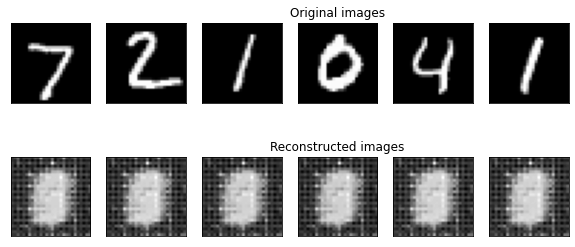

KeyboardInterrupt: 

In [9]:
num_epochs = 5

for epoch in range(num_epochs):
   train_loss = train_epoch(model, trainloader,optim)
   val_loss = test_epoch(model, valloader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   plot_ae_outputs(model.encoder, model.decoder,n=6)




In [ ]:
encoded_samples = []
for sample in tqdm(testset):
    img = sample[0].unsqueeze(0)
    label = sample[1]
    # Encode image
    model.eval()
    with torch.no_grad():
        encoded_img  = model.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
encoded_samples = pd.DataFrame(encoded_samples)



from sklearn.manifold import TSNE
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import silhouette_score
import plotly.express as px

#Davies-Bouldin Index
db_index = davies_bouldin_score(encoded_samples, encoded_samples.label)
print(db_index)

#Calinski-Harabasz Index
ch_score = calinski_harabasz_score(encoded_samples, encoded_samples.label)
print(ch_score)

# #Silhouette Coefficient
# s_coeff = silhouette_score(encoded_samples, encoded_samples.label,  metric=metrics.PoincareDistance)
# print(s_coeff)

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

100%|██████████| 10000/10000 [00:52<00:00, 190.11it/s]


0.8945389487098714
44951.43425237138


In [ ]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})

# #Davies-Bouldin Index
# db_index = davies_bouldin_score(tsne_results, encoded_samples.label)
# print(db_index)

# #Calinski-Harabasz Index
# ch_score = calinski_harabasz_score(tsne_results, encoded_samples.label)
# print(ch_score)

# #Silhouette Coefficient
# s_coeff = silhouette_score(tsne_results, encoded_samples.label)
# print(s_coeff)
fig.show()